In [1]:
import os
from mvpa2.suite import *
import glob
import pandas as pd
import sys

# print sys.argv[0]
# s = sys.argv[1]
# print(s)
# task = sys.argv[2]
# print(task)
# nruns = int(sys.argv[3])
# con1 = int(sys.argv[4])
# mask = sys.argv[5]
# print(mask)
s=1
task='voice_single'
nruns=6
con1=1
mask='brain'

/home/language/laugig/.conda/envs/env2.7/lib/python2.7/site-packages/mvpa2/base/hdf5.py:40: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  import h5py.highlevel  # >= 2.8.0, https://github.com/h5py/h5py/issues/1063
/home/language/laugig/.conda/envs/env2.7/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


In [2]:
#s=2
subj = str(s).zfill(2)
subjdir = 'sub-0'+subj

spmdir = '/project/3011226.02/bids/derivatives/SPM/firstlevel/'+subjdir
fmriprepdir = '/project/3011226.02/bids/derivatives/fmriprep/'+subjdir+'/ses-mri01/func/'
MVPAdir = '/project/3011226.02/bids/derivatives/pyMVPA/'+subjdir+'/single/'

# loading production runs
if not os.path.isdir(MVPAdir):
    os.mkdir(MVPAdir)

if not os.path.isdir(os.path.join(MVPAdir,'accs')):
    os.mkdir(os.path.join(MVPAdir,'accs'))

if not os.path.isdir(os.path.join(MVPAdir,'perms')):
    os.mkdir(os.path.join(MVPAdir,'perms'))  
  
run_datasets = []

if mask == 'brain':

    mask_fname = fmriprepdir+subjdir+'_ses-mri01_task-production_acq-ep3d_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
else:
    mask_fname = '/project/3011226.02/bids/derivatives/ROIs/' + mask +'.nii'


col = task + '_' + mask


count = 0
#sess = "comp_cat_plan"

for run_id in range(con1,con1+nruns):

    #for sess in ["mb8all_cond","me3all_cond"]:

    spmT = str(run_id).zfill(4)

    bold_fname = os.path.join(spmdir, task, 'spmT_'+spmT+'.nii')

    run_ds = fmri_dataset(samples = bold_fname, targets = 'M', chunks = count%nruns, mask=mask_fname)
    count += 1
    run_datasets.append(run_ds)

count = 0
for run_id in range(con1+nruns,con1+nruns+nruns):

    spmT = str(run_id).zfill(4)

    bold_fname = os.path.join(spmdir, task, 'spmT_'+spmT+'.nii')

    run_ds = fmri_dataset(samples = bold_fname, targets = 'S', chunks = count%nruns, mask=mask_fname)
    count += 1
    run_datasets.append(run_ds)
    
fds = vstack(run_datasets, a=0)

fds.sa


fds = remove_nonfinite_features(fds)


 * Please note: warnings are printed only once, but underlying problem might occur many times *


/home/language/laugig/.conda/envs/env2.7/lib/python2.7/site-packages/mvpa2/clfs/distance.py:160: FutureWarning: Conversion of the second argument of issubdtype from `'f'` to `np.floating` is deprecated. In future, it will be treated as `np.float32 == np.dtype('f').type`.
  if not np.issubdtype(data1.dtype, 'f') \
/home/language/laugig/.conda/envs/env2.7/lib/python2.7/site-packages/mvpa2/misc/attrmap.py:153: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.string_ == np.dtype(str).type`.
  if not np.issubdtype(attr.dtype, str) and not self.mapnumeric:
/home/language/laugig/.conda/envs/env2.7/lib/python2.7/site-packages/mvpa2/clfs/libsvmc/svm.py:215: FutureWarning: Conversion of the second argument of issubdtype from `'c'` to `str` is deprecated. In future, it will be treated as `np.string_ == np.dtype('c').type`.
  if ( np.issubdtype(self.ca.trained_targets.dtype, 'c') or


0.6666666666666666
0.8333333333333334


/home/language/laugig/.conda/envs/env2.7/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


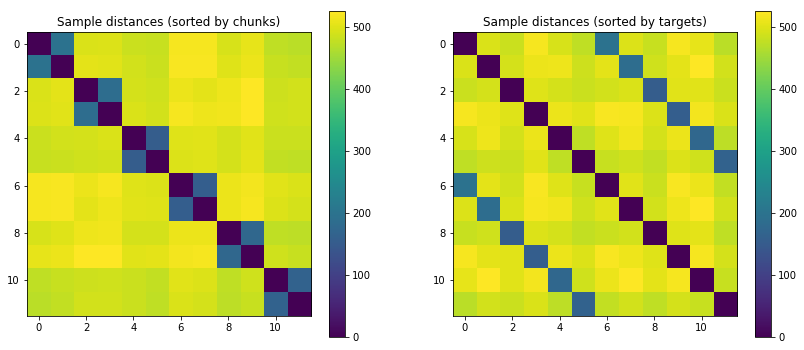

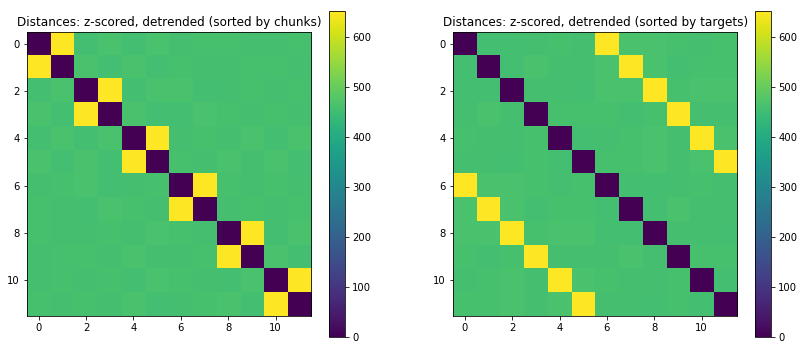

In [3]:

# next only works with floating point data

fds.samples = fds.samples.astype('float')

pl.figure(figsize=(14, 6))

pl.subplot(121)

plot_samples_distance(fds, sortbyattr='chunks')

pl.title('Sample distances (sorted by chunks)')

pl.subplot(122)

plot_samples_distance(fds, sortbyattr='targets')

pl.title('Sample distances (sorted by targets)')

#pl.savefig(os.path.join(MVPAdir, col+'.png'), dpi=150)

clf = LinearCSVMC()

cvte = CrossValidation(clf, NFoldPartitioner(cvtype=1),

                       errorfx=lambda p, t: np.mean(p == t),

                       enable_ca=['stats'])

cv_results = cvte(fds)

res1 = np.mean(cv_results)
print(res1)
#with open("/project/3011226.02/bids/derivatives/pyMVPA/"+subjdir+"/single/accs/"+col+".txt", "w") as text_file:
#    text_file.write(str(res1))
# z-score features individually per chunk

zscore(fds)

pl.figure(figsize=(14, 6))

pl.subplot(121)

plot_samples_distance(fds,sortbyattr='chunks')

pl.title('Distances: z-scored, detrended (sorted by chunks)')

pl.subplot(122)

plot_samples_distance(fds, sortbyattr='targets')

pl.title('Distances: z-scored, detrended (sorted by targets)')

#pl.savefig(os.path.join(MVPAdir, col+'_z.png'), dpi=150)

clf = LinearCSVMC()

cvte = CrossValidation(clf, NFoldPartitioner(cvtype=1),

                       errorfx=lambda p, t: np.mean(p == t),

                       enable_ca=['stats'])

cv_results = cvte(fds)

res2 = np.mean(cv_results)
print(res2)
#with open("/project/3011226.02/bids/derivatives/pyMVPA/"+subjdir+"/single/accs/"+col+"_z.txt", "w") as text_file:
#    text_file.write(str(res2))

In [4]:

### PERMUTATIONS
res1=[]
res2=[]
for p in range(1,101):
    perm=AttributePermutator("targets", limit="chunks",rng=7*p)

    print perm

    fds=perm(fds)

    print fds.targets

    clf = LinearCSVMC()

    cvte = CrossValidation(clf, NFoldPartitioner(cvtype=1),

                           errorfx=lambda p, t: np.mean(p == t),

                           enable_ca=['stats'])

    cv_results = cvte(fds)

    res1.append(np.mean(cv_results))
    #print(res1)
    

    
    # z-score features individually per chunk

    zscore(fds)

    clf = LinearCSVMC()

    cvte = CrossValidation(clf, NFoldPartitioner(cvtype=1),

                           errorfx=lambda p, t: np.mean(p == t),

                           enable_ca=['stats'])

    cv_results = cvte(fds)

    res2.append(np.mean(cv_results))
#    print(res2)
 #   with open("/project/3011226.02/bids_pilot/derivatives/pyMVPA/"+subjdir+"/"+col+"_z.txt", "w") as text_file:
#        text_file.write(str(res2))

#with open("/project/3011226.02/bids/derivatives/pyMVPA/"+subjdir+"/single/accs/"+col+"_perms.txt", "w") as text_file:
#    text_file.write(str(res1))
    
#with open("/project/3011226.02/bids/derivatives/pyMVPA/"+subjdir+"/single/accs/"+col+"_z_perms.txt", "w") as text_file:
#    text_file.write(str(res2))   



<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'S' 'M' 'S' 'M' 'M' 'S' 'M' 'S' 'M' 'S' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'S' 'M' 'M' 'M' 'S' 'S' 'M' 'S' 'S' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'M' 'S' 'S' 'S' 'S' 'S' 'S' 'M' 'M' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'M' 'M' 'M' 'M' 'S' 'S' 'S' 'S' 'S' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'S' 'M' 'M' 'S' 'S' 'S' 'M' 'S' 'S' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['S' 'M' 'M' 'S' 'S' 'S' 'M' 'S' 'S' 'M' 'M' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'S' 'S' 'M' 'M' 'S' 'S' 'M' 'M' 'S' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'S' 'S' 'M' 'S' 'M' 'S' 'M' 'M' 'S' 'M' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['S' 'M' 'S' 'M' 'M' 'S'

<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'M' 'M' 'S' 'S' 'S' 'S' 'S' 'S' 'M' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'S' 'M' 'S' 'S' 'S' 'S' 'M' 'S' 'M' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['S' 'M' 'M' 'S' 'M' 'S' 'M' 'S' 'S' 'M' 'S' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['S' 'S' 'M' 'M' 'M' 'M' 'M' 'M' 'S' 'S' 'S' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'S' 'S' 'M' 'S' 'S' 'S' 'M' 'M' 'S' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['S' 'M' 'M' 'S' 'S' 'M' 'M' 'S' 'S' 'M' 'M' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'M' 'M' 'M' 'S' 'S' 'S' 'S' 'S' 'S' 'M' 'M']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['S' 'S' 'S' 'M' 'M' 'M' 'M' 'M' 'M' 'S' 'S' 'S']
<AttributePermutator: targets, assure=False, limit=chunks, n=1>
['M' 'S' 'S' 'S' 'S' 'M'

In [ ]:
# SEARCHLIGHT
if mask == 'brain':
    clf = LinearCSVMC()

    cvte = CrossValidation(clf, NFoldPartitioner(cvtype=1))

    # split dataset into all possible sphere neighbourhoods that intersect with the brain

    sl = sphere_searchlight(cvte, radius=5, postproc=mean_sample())

    res = sl(fds)

    res.samples

    sphere_errors = res.samples[0]
    res_mean = np.mean(res)
    res_std = np.std(res)
    # we deal with errors here, hence 1.0 minus
    chance_level = 1.0 - (1.0 / len(fds.uniquetargets))
    chance_level
    print(res_mean)

    map2nifti(fds, 1.0 - sphere_errors).to_filename('/project/3011226.02/bids/derivatives/pyMVPA/'+subjdir+'/single/sl_'+col+'.nii.gz')
    
    

    
    
    